<a href="https://colab.research.google.com/github/Rhysus85/MA5851_MasterClass1/blob/main/Video_to_image_PyScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Check if using GPU 
#google suggestion as I have set up a subscription to get dedicated GPUs
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 14 02:24:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#Check memory usage/availability
#google suggestion as I have set up a subscription to get dedicated GPUs
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#load libraries
#mount drive to access data 
import os 
from google.colab import drive

import cv2 
import numpy as np
from google.colab.patches import cv2_imshow #directed by google to reduce crashing
import pandas as pd
import csv
import math
from os.path import exists
import time

import matplotlib.pyplot as plt    # for plotting the images
from PIL import Image
from imutils import paths
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.models import Model

from tensorflow.keras.utils import load_img
from numpy import expand_dims

#from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
import argparse



In [ ]:
#I used my drive for the POC
drive.mount('/content/drive',force_remount=True)
#set directory
os.chdir('/content/drive/MyDrive/Ocean_Infinity')
os.listdir()

Mounted at /content/drive


['Output',
 'Dataset',
 'Raw Video',
 'Raw Dataset',
 'POC',
 'image_metadata.csv',
 'hp_output',
 'my_dir',
 'Dataset 2 Class',
 'Raw_Video_2',
 'Raw_Dataset_2']

Process here is to take video, convert to images based on video fps and store in specific folder to match the visibility label.

In [ ]:
def extract_images_from_video_files(raw_video_path, raw_image_path):
  image_metadata_row = pd.DataFrame()     
  image_metadata = pd.DataFrame()

  #log time
  time_start = time.time()
  for path, subdirs, files in os.walk(raw_video_path): 
    max_image_cnt = 0
    for name in files:
            image_cnt = 0
            
            print(name)
            #print('ospath+name: '+(os.path.join(path, name)))
            cap = cv2.VideoCapture((os.path.join(path, name)))    
            #metadata for video
            video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
            video_fps = cap.get(5)
            video_width = cap.get(3)
            video_height = cap.get(4)
            video_name = name
            video_path = path
            video_size = (math.trunc(os.path.getsize((os.path.join(path, name)))))/1000/1000 #megabytes         
            #create image output path
            label= path.rsplit('/', 1)[1]
            image_dataset_path = raw_image_path+label       
            while(cap.isOpened()):
              ret, frame = cap.read()
              if ret == False:
                break
              frame_ID = cap.get(1)
              try:          
                  cap.set(cv2.CAP_PROP_POS_MSEC,(image_cnt*1000))#this will take 1 file every second
                  image_frame_time = cv2.CAP_PROP_POS_MSEC

                  img_name = label+'_'+str(image_cnt)+'_Original.jpg'              
                  cv2.imwrite((image_dataset_path+'/'+img_name),frame)
                  image_loc = (image_dataset_path+'/'+img_name)
                  image_cnt +=1  
                  max_image_cnt +=1 
                #create metadata rows for excel extract
                  image_metadata_raw = [video_path,
                                        video_size,
                                        video_length,
                                        video_name,
                                        video_fps,
                                        video_width,
                                        video_height,
                                        image_dataset_path,
                                        label,
                                        frame_ID,
                                        img_name,
                                        image_frame_time
                                        ]
                  image_metadata_row = pd.DataFrame(image_metadata_raw).T       
                  image_metadata = image_metadata.append(image_metadata_row)
   
                  #crop images to remove header 
                  try:
                    #crop_name = label+'_'+str(image_cnt)+'.jpg'  
                    img = cv2.imread(image_loc)
                    crop_img = img[100:h,0:w]
                    crop_image_path = (image_dataset_path+'/'+img_name)
                    cv2.imwrite(crop_image_path,crop_img)
                    cv2.destroyAllWindows()
                  except:
                    ("Issue with cropping")

   
              except:
                print("Image %d unsuccessful." % image_cnt)
                continue
              print("Successully created %d images." % image_cnt)
              print("%d images remaining." % ((video_length/video_fps)-image_cnt))  
            
            cap.release()
            cv2.destroyAllWindows()          
    #else:
    #  print('error #2')
            #continue

  ## # ### ##############################    
  #do this at the end - add column headers to metadata pd
  image_metadata.columns=['video_path',
                          'video_size',
                          'video_length',
                          'video_name',
                          'video_fps',
                          'video_width',
                          'video_height',
                          'image_dataset_path',
                          'label',
                          'frame_ID',
                          'img_name'
                        ]
          
  #create the image metadata file
  filename = 'image_metadata.csv'

  if os.path.exists(filename):
    image_metadata.to_csv(filename, mode='a', index=False, header=False)
    print("Metadata extract added to existing file.")
  else:
    image_metadata.to_csv(filename, mode='a', index=False, header=True)
    print("Metadata extract created new file.")

      #prep output data
          #log time
  time_end = time.time()
  ## # ### ############################## 
  print("\nExtraction completed. \n%d frames extracted." % max_image_cnt)
  print("Images were extracted in %d seconds." % (time_end-time_start))


In [ ]:
#Run the function to create the dataset

#set directory
raw_video_path = '/content/drive/MyDrive/Ocean_Infinity/Raw_Video_2/'
raw_image_path = '/content/drive/MyDrive/Ocean_Infinity/Raw_Dataset_2/'

#testing with 1 actual file in a specific folder
#raw_video_path = '/content/drive/MyDrive/Ocean_Infinity/Raw Video/Poor/'

#run the function to extract images from our raw video files
#remove hyphen first
extract_images_from_video_files(raw_video_path, raw_image_path)

#THIS SECTION CREATES AUGMENTED IMAGES

##Colour Brightness

In [ ]:
master_cnt = 0

for path, subdirs, files in os.walk(raw_image_path): 
  #print(path)
  label= path.rsplit('/', 1)[1]
  #print(label)
  image_cnt = 0  

  for name in files:
    if 'Original' in name: #
      image_cnt +=1
      master_cnt +=1
      #print(name)
      image_dataset_path = raw_image_path+label 
      img_name = label+'_'+str(image_cnt)+'_Original.jpg' 
      img = load_img(image_dataset_path+'/'+name)
      try:
        #convert image to array and expand to 4D  
        img_data = np.asarray(img)
        img_data = expand_dims(img_data, 0)
        # create image data augmentation generator from 50% to 150% brightness
        datagen = ImageDataGenerator(brightness_range=[0.75,1.5])
        conv_img = datagen.flow(img_data, batch_size=1)
        iter = datagen.flow(img_data, batch_size=1) 

        #create 5 additional images
        for i in range(1):
          batch = iter.next()
          image = batch[0].astype('uint8')
          cv2.imwrite((image_dataset_path+'/'+img_name),image)
        print(name+" successfully augmented")

      except:
        print("Failed to create additional image for: "+name)           

print("new images created: "+str(master_cnt)  )

new images created: 0


##Horizontal_Flip

In [ ]:
master_cnt = 0

for path, subdirs, files in os.walk(raw_image_path): 
  #print(path)
  label= path.rsplit('/', 1)[1]
  #print(label)
  image_cnt = 0  
  
  for name in files:
    if 'Original' in name: #
      image_cnt +=1
      master_cnt +=1
      #print(name)
      image_dataset_path = raw_image_path+label 
      img_name = label+'_'+str(image_cnt)+'_Original.jpg' 
      img = load_img(image_dataset_path+'/'+name)
      try:
        #convert image to array and expand to 4D  
        img_data = np.asarray(img)
        img_data = expand_dims(img_data, 0)
        # create image data augmentation generator to flip each image
        datagen = ImageDataGenerator(horizontal_flip=True)
        conv_img = datagen.flow(img_data, batch_size=1)
        iter = datagen.flow(img_data, batch_size=1) 

        #create 5 additional images
        for i in range(1):
          batch = iter.next()
          image = batch[0].astype('uint8')
          cv2.imwrite((image_dataset_path+'/'+img_name),image)
        print(name+" successfully augmented")

      except:
        print("Failed to create additional image for: "+name)

print("new images created: "+str(master_cnt)  )

##Random Zoom

In [ ]:
master_cnt = 0

for path, subdirs, files in os.walk(raw_image_path): 
  #print(path)
  label= path.rsplit('/', 1)[1]
  #print(label)
  image_cnt = 0  

  for name in files:
    if 'Original' in name: #
      image_cnt +=1
      master_cnt +=1
      #print(name)
      image_dataset_path = raw_image_path+label 
      img_name = label+'_'+str(image_cnt)+'_Original.jpg' 
      img = load_img(image_dataset_path+'/'+name)
      try:
        #convert image to array and expand to 4D  
        img_data = np.asarray(img)
        img_data = expand_dims(img_data, 0)
        # create image data augmentation generator zoom out by 50% to 80%
        datagen = ImageDataGenerator(zoom_range=[0.5,0.8])
        conv_img = datagen.flow(img_data, batch_size=1)
        iter = datagen.flow(img_data, batch_size=1) 

        #create 5 additional images
        for i in range(1):
          batch = iter.next()
          image = batch[0].astype('uint8')
          cv2.imwrite((image_dataset_path+'/'+img_name),image)
        print(name+" successfully augmented")

      except:
        print("Failed to create additional image for: "+name)

print("new images created: "+str(master_cnt)  )

Very Good_0_Original.jpg successfully augmented
Very Good_1_Original.jpg successfully augmented
Very Good_2_Original.jpg successfully augmented
Very Good_3_Original.jpg successfully augmented
Very Good_4_Original.jpg successfully augmented
Very Good_5_Original.jpg successfully augmented
Very Good_6_Original.jpg successfully augmented
Very Good_7_Original.jpg successfully augmented
Very Good_8_Original.jpg successfully augmented
Very Good_9_Original.jpg successfully augmented
Very Good_10_Original.jpg successfully augmented
Very Good_11_Original.jpg successfully augmented
Very Good_12_Original.jpg successfully augmented
Very Good_13_Original.jpg successfully augmented
Very Good_14_Original.jpg successfully augmented
Very Good_15_Original.jpg successfully augmented
Very Good_16_Original.jpg successfully augmented
Very Good_17_Original.jpg successfully augmented
Very Good_18_Original.jpg successfully augmented
Very Good_19_Original.jpg successfully augmented
Very Good_20_Original.jpg succ

##Random Shifts

In [ ]:
master_cnt = 0

for path, subdirs, files in os.walk(raw_image_path): 
  #print(path)
  label= path.rsplit('/', 1)[1]
  #print(label)
  image_cnt = 0  

  for name in files:
    if 'Original' in name: #
      image_cnt +=1
      master_cnt +=1
      #print(name)
      image_dataset_path = raw_image_path+label 
      img_name = label+'_'+str(image_cnt)+'_Original.jpg' 
      img = load_img(image_dataset_path+'/'+name)
      try:
        #convert image to array and expand to 4D  
        img_data = np.asarray(img)
        img_data = expand_dims(img_data, 0)
        # create image data augmentation generator shift 20% left/right/up/down
        datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
        conv_img = datagen.flow(img_data, batch_size=1)
        iter = datagen.flow(img_data, batch_size=1) 

        #create 5 additional images
        for i in range(1):
          batch = iter.next()
          image = batch[0].astype('uint8')
          cv2.imwrite((image_dataset_path+'/'+img_name),image)
        print(name+" successfully augmented")

      except:
        print("Failed to create additional image for: "+name)

print("new images created: "+str(master_cnt)  )

#This section will do some exploring of the raw dataset

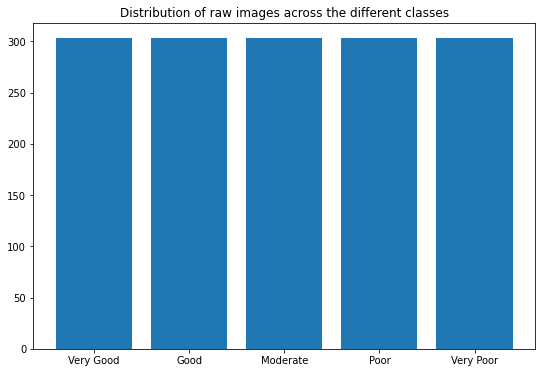

In [ ]:
#visual to show spread of data across the classes
image_list = ['Very Good','Good','Moderate','Poor','Very Poor']
#raw_image_path = os.getcwd()+'/Raw Dataset/'
no_imgs = {}
for i in image_list:
    no_images = len(os.listdir(raw_image_path+i+'/'))
    no_imgs[i] = no_images
    
plt.figure(figsize=(9,6))
plt.bar(range(len( no_imgs)), list(no_imgs.values()),align='center')
plt.xticks(range(len(no_imgs)),list(no_imgs.keys()))
plt.title("Distribution of raw images across the different classes")
plt.show()

THIS SECTION WILL LOOK AT RESIZING IMAGES - might not need it until we are ready for the model ingest

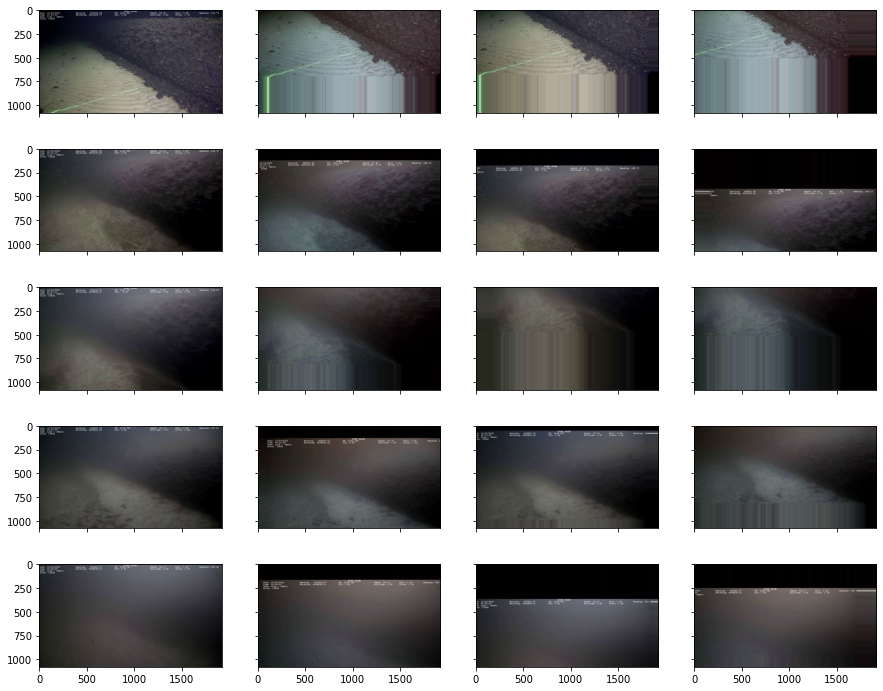

In [ ]:
#show original images in a grid
dir = raw_image_path

Images = os.listdir(dir)
img_arr_orig = []

for path, subdirs, files in os.walk(dir): 
  label= path.rsplit('/', 1)[1]
  for image in files[0:4]:
    image_dataset_path = dir+label+'/'+image   
    #print(image_dataset_path)
    try:
      img = Image.open(image_dataset_path)
      img = np.asarray(img)
      img_arr_orig.append(img)
    except:
      continue

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
for ax, im in zip(grid, img_arr_orig):
    ax.imshow(im)
plt.show()

  

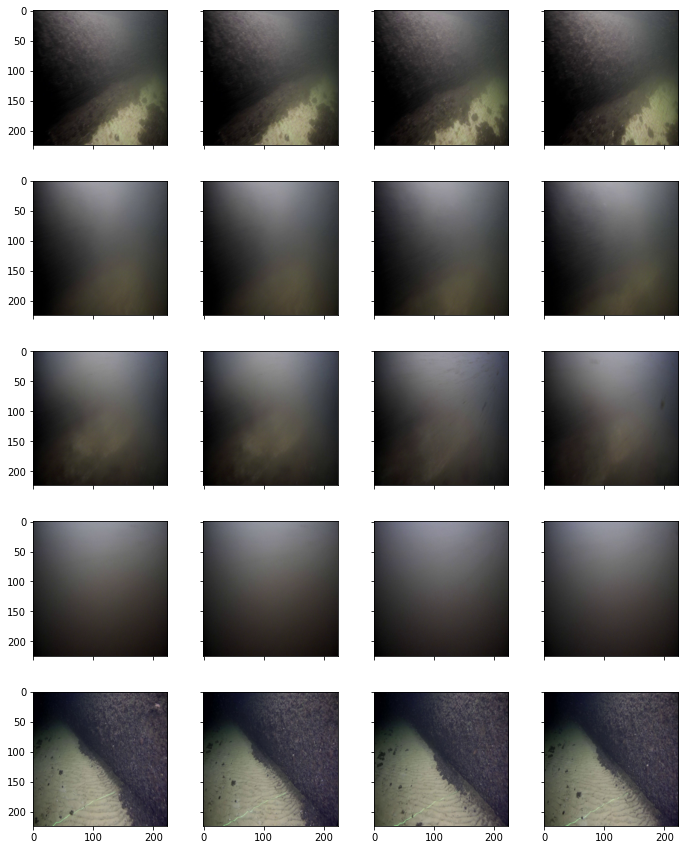

In [ ]:
#show resized images in a grid
dir = raw_image_path

Images = os.listdir(dir)
img_arr_resize = []

for path, subdirs, files in os.walk(dir): 
  label= path.rsplit('/', 1)[1]
  for image in files[0:4]:
    image_dataset_path = dir+label+'/'+image   
    #print(image_dataset_path)
    try:
      img = Image.open(image_dataset_path)
      img = img.resize((224,224))
      img = np.asarray(img)
      img_arr_resize.append(img)
    except:
      continue

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 4),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
for ax, im in zip(grid, img_arr_resize):
    ax.imshow(im)
plt.show()

  

THIS SECTION WILL SPLIT DATA INTO TRAIN/TEST/VAL DATASETS

In [ ]:
#take images from raw directory and split into train, val and test
input_dir = raw_image_path
output_dir = '/content/drive/MyDrive/Ocean_Infinity/Dataset_2/'

train_ratio = 0.75 #training dataset
val_ratio = 0.20   #labelled to evaluate performance
test_ratio = 0.05  #unknown labels to demonstrate

splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(train_ratio,val_ratio,test_ratio)) 


Copying files: 1515 files [00:12, 117.06 files/s]


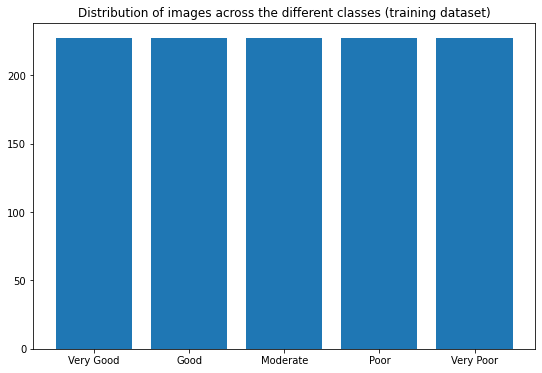

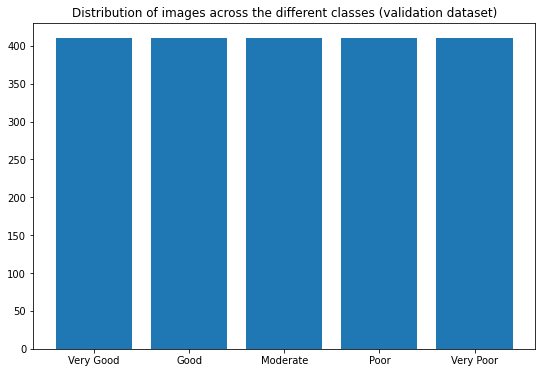

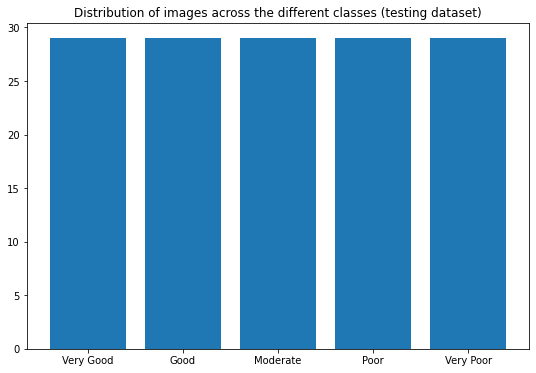

In [ ]:
#visual to show spread of data across the classes
split_folders = ['train','test','val']
image_list = ['Very Good','Good','Moderate','Poor','Very Poor']

raw_image_path = os.getcwd()+'/Dataset_2/train/'
no_imgs = {}
for i in image_list:
    no_images = len(os.listdir(raw_image_path+i+'/'))
    no_imgs[i] = no_images
    
plt.figure(figsize=(9,6))
plt.bar(range(len( no_imgs)), list(no_imgs.values()),align='center')
plt.xticks(range(len(no_imgs)),list(no_imgs.keys()))
plt.title("Distribution of images across the different classes (training dataset)")
plt.show()

raw_image_path = os.getcwd()+'/Dataset/val/'
no_imgs = {}
for i in image_list:
    no_images = len(os.listdir(raw_image_path+i+'/'))
    no_imgs[i] = no_images
    
plt.figure(figsize=(9,6))
plt.bar(range(len( no_imgs)), list(no_imgs.values()),align='center')
plt.xticks(range(len(no_imgs)),list(no_imgs.keys()))
plt.title("Distribution of images across the different classes (validation dataset)")
plt.show()

raw_image_path = os.getcwd()+'/Dataset/test/'
no_imgs = {}
for i in image_list:
    no_images = len(os.listdir(raw_image_path+i+'/'))
    no_imgs[i] = no_images
    
plt.figure(figsize=(9,6))
plt.bar(range(len( no_imgs)), list(no_imgs.values()),align='center')
plt.xticks(range(len(no_imgs)),list(no_imgs.keys()))
plt.title("Distribution of images across the different classes (testing dataset)")
plt.show()


#CREATE OUR MODEL

In [ ]:
#Image.LOAD_TRUNCATED_IMAGES = True

training_local_path = 'Dataset_2/train/'
validation_local_path = 'Dataset_2/val/'
graph_path = os.makedirs("Dataset_2/output/graph/", exist_ok=True)

datagen = ImageDataGenerator(rescale=1.0/255.0)
img_width=224
img_height=224
batch_size = 50

train_batches = datagen.flow_from_directory(training_local_path
                                            ,class_mode='categorical'
                                            ,batch_size = batch_size
                                            ,target_size=(img_height, img_width))

val_batches = datagen.flow_from_directory(validation_local_path
                                          ,class_mode='categorical'
                                          ,batch_size = batch_size
                                          ,target_size=(img_height, img_width))

#to show the description when predicting
label_map = (train_batches.class_indices)



Found 1135 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


{'Good': 0, 'Moderate': 1, 'Poor': 2, 'Very Good': 3, 'Very Poor': 4}

In [ ]:
X_train = train_batches[0][0]
y_train = train_batches[0][1]
X_val = val_batches[0][0]
y_val = val_batches[0][1]

In [ ]:
#confirm x = (batch, h, w and channel)
#confirm y = (batch, class)
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)

X_train shape: (50, 224, 224, 3)
X_val shape: (50, 224, 224, 3)
y_train shape: (50, 5)
y_val shape: (50, 5)


##MODEL 1

In [ ]:
#model_1 
model_1 = tf.keras.Sequential()
#input layer
model_1.add(Conv2D(filters=11, kernel_size=(3,3), activation='relu', input_shape=(img_width, img_height, 3)))
model_1.add(MaxPooling2D(pool_size=(2,2)))
## 1st convolultion layer
model_1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# flatten and classify
## flattern spacial information into a vector, and learn the final probability distribution for each class
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.4))
model_1.add(Dense(5, activation='softmax'))

model_1.compile(optimizer=Adam(learning_rate=0.001)
               ,loss='categorical_crossentropy'
               , metrics=["accuracy",
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()]
                )
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 11)      308       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 11)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     12800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 373248)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss'
                              ,patience=2
                              )

In [ ]:
history_1 = model_1.fit(train_batches
                       ,validation_data=val_batches
                       ,epochs=10
                       ,steps_per_epoch=len(train_batches)
                       ,validation_steps=len(val_batches)
                       ,verbose=1
                       ,callbacks =[early_stopping]
                        )

Epoch 1/10
23/23 [==============================] - 50s 2s/step - loss: 4.2087 - accuracy: 0.4396 - precision: 0.4794 - recall: 0.2863 - val_loss: 0.9965 - val_accuracy: 0.6000 - val_precision: 0.8750 - val_recall: 0.3500
Epoch 2/10
23/23 [==============================] - 31s 1s/step - loss: 0.6702 - accuracy: 0.7119 - precision: 0.8547 - recall: 0.6115 - val_loss: 0.5415 - val_accuracy: 0.7733 - val_precision: 0.8761 - val_recall: 0.6833
Epoch 3/10
23/23 [==============================] - 33s 1s/step - loss: 0.4006 - accuracy: 0.8344 - precision: 0.8794 - recall: 0.7771 - val_loss: 0.3808 - val_accuracy: 0.8133 - val_precision: 0.8163 - val_recall: 0.8000
Epoch 4/10
23/23 [==============================] - 32s 1s/step - loss: 0.2854 - accuracy: 0.8784 - precision: 0.9013 - recall: 0.8529 - val_loss: 0.3467 - val_accuracy: 0.9333 - val_precision: 0.9490 - val_recall: 0.9300
Epoch 5/10
23/23 [==============================] - 32s 1s/step - loss: 0.2097 - accuracy: 0.9181 - precision: 0

In [ ]:
train_scores = model_1.evaluate(train_batches, verbose=1)
val_scores = model_1.evaluate(val_batches, verbose=1)

# print the final model metrics once the training job completes
print('Training loss       :', train_scores[0])
print('Training accuracy   :', train_scores[1])
print('Training precision:', train_scores[2])
print('Training recall:', train_scores[3])

print('Test loss       :', val_scores[0])
print('Test accuracy   :', val_scores[1])
print('Test precision:', val_scores[2])
print('Test recall:', val_scores[3])

6/6 [==============================] - 7s 1s/step - loss: 0.3173 - accuracy: 0.8833 - precision: 0.8863 - recall: 0.8833
Training loss       : 0.14405705034732819
Training accuracy   : 0.9374449253082275
Training precision: 0.9382171034812927
Training recall: 0.9365638494491577
Test loss       : 0.3172953426837921
Test accuracy   : 0.8833333253860474
Test precision: 0.8862876296043396
Test recall: 0.8833333253860474


In [ ]:
#visualise loss and accuary per epoch
def vis_training(hlist,file_name, start):
    # This function will help to visualize the loss, val_loss, accuracy etc.

    # getting history of all kpi for each epochs
    loss = np.concatenate([hlist.history['loss']])
    val_loss = np.concatenate([hlist.history['val_loss']])
    acc = np.concatenate([hlist.history['accuracy']])
    val_acc = np.concatenate([hlist.history['val_accuracy']])
    epoch_range = range(1,len(loss)+1)

    # Block for training vs validation loss
    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()
    # Block for training vs validation accuracy
    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig('./Output/graph/' +file_name+'.png')




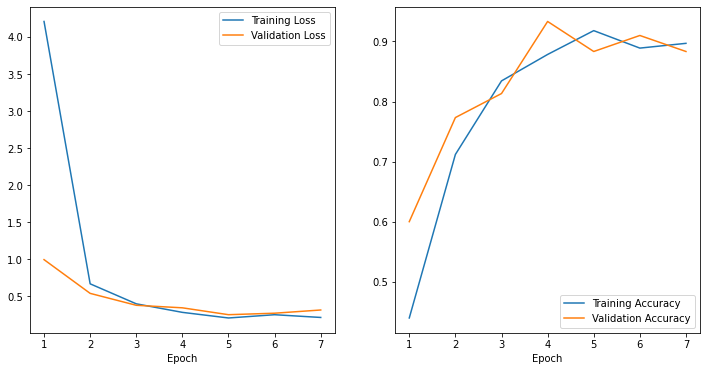

In [ ]:
#output the graphs to png file.
file_name = 'model_5_train_log_local'  
vis_training(history_1, file_name, start=1)

In [ ]:
#save model
output_dir = '/content/drive/MyDrive/Ocean_Infinity/Output/'
model_1_path = os.makedirs("Output/Model_5/", exist_ok=True)
model_1_subfolder = '/Model_5/'
model_1.save(output_dir+model_1_subfolder)

In [ ]:
  #saving a single model file
#output_dir = '/content/drive/MyDrive/Ocean_Infinity/Output/'
###model_1_path = os.makedirs("Output/Model_1/", exist_ok=True)
#model_1_subfolder = '/Model_1/'
#model_1.save(output_dir+model_1_subfolder+'/Model_1.h5')

##MODEL 2

In [ ]:
#model_2 uses transfer learning: InceptionV3 model
model_2 = keras.applications.InceptionV3(include_top=False, # Leave out the last fully connected layer
                  input_shape=(img_width,img_height,3)
                  ,weights="imagenet"
                  ,pooling="max"
                  )
# mark loaded layers as not trainable
for layer in model_2.layers:
  layer.trainable = False
	# add new classifier layers
flatten = Flatten()(model_2.output)
  
# add a fully connected layer with 256 hidden units, ReLU activation and he_uniform initialisation
dense = Dense(256, activation='relu', kernel_initializer='he_uniform')(flatten)
output = Dense(5, activation='softmax')(dense)
	
# define new model_2
model_2 = Model(inputs=model_2.inputs, outputs=output)
# compile model
model_2.compile(optimizer=Adam(learning_rate=0.001)
                ,loss='categorical_crossentropy'
                ,metrics=["accuracy",
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()]
                )
model_2.summary()



In [ ]:
# fit model_2
history_2 = model_2.fit(train_batches
                       ,steps_per_epoch=len(train_batches)
                       ,validation_data=val_batches
                       ,validation_steps=len(val_batches)
                       ,epochs=10
                       ,verbose=1
                        )

Epoch 1/10
23/23 [==============================] - 53s 2s/step - loss: 1.5418 - accuracy: 0.6267 - precision_1: 0.6411 - recall_1: 0.5938 - val_loss: 0.4388 - val_accuracy: 0.7800 - val_precision_1: 0.8383 - val_recall_1: 0.7433
Epoch 2/10
23/23 [==============================] - 46s 2s/step - loss: 0.3742 - accuracy: 0.8311 - precision_1: 0.8578 - recall_1: 0.7938 - val_loss: 0.3964 - val_accuracy: 0.7967 - val_precision_1: 0.8047 - val_recall_1: 0.7967
Epoch 3/10
23/23 [==============================] - 42s 2s/step - loss: 0.3012 - accuracy: 0.8702 - precision_1: 0.8880 - recall_1: 0.8524 - val_loss: 0.3116 - val_accuracy: 0.8500 - val_precision_1: 0.8720 - val_recall_1: 0.8400
Epoch 4/10
23/23 [==============================] - 40s 2s/step - loss: 0.2778 - accuracy: 0.8871 - precision_1: 0.8983 - recall_1: 0.8711 - val_loss: 0.3033 - val_accuracy: 0.8633 - val_precision_1: 0.8682 - val_recall_1: 0.8567
Epoch 5/10
23/23 [==============================] - 41s 2s/step - loss: 0.2610 -

In [ ]:
#evaluate model_2
train_scores_2 = model_2.evaluate(train_batches, verbose=1)
val_scores_2 = model_2.evaluate(val_batches, verbose=1)

# print the final model metrics once the training job completes
print('Training loss       :', train_scores_2[0])
print('Training accuracy   :', train_scores_2[1])
print('Training precision:', train_scores_2[2])
print('Training recall:', train_scores_2[3])

print('Test loss       :', val_scores_2[0])
print('Test accuracy   :', val_scores_2[1])
print('Test precision:', val_scores_2[2])
print('Test recall:', val_scores_2[3])

6/6 [==============================] - 8s 1s/step - loss: 0.3213 - accuracy: 0.8567 - precision_1: 0.8624 - recall_1: 0.8567
Training loss       : 0.18235889077186584
Training accuracy   : 0.9191111326217651
Training precision: 0.921005368232727
Training recall: 0.9120000004768372
Test loss       : 0.3213266134262085
Test accuracy   : 0.8566666841506958
Test precision: 0.8624160885810852
Test recall: 0.8566666841506958


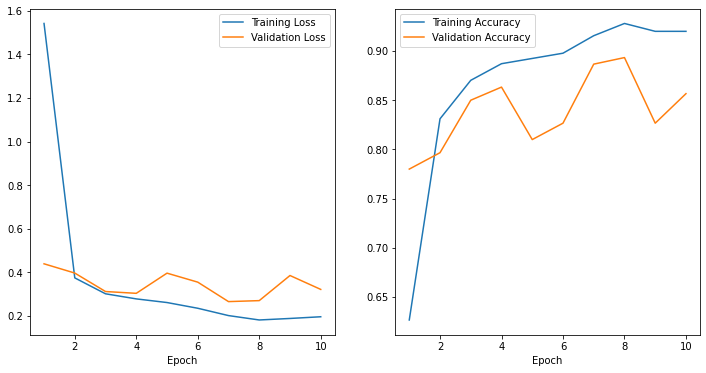

In [ ]:
#output the graphs to png file.
file_name = 'model_2_train_log_local'  
vis_training(history_2, file_name, start=1)


In [ ]:
#save model_1=2
output_dir = '/content/drive/MyDrive/Ocean_Infinity/Output/'
model_2_path = os.makedirs("Output/Model_2/", exist_ok=True)
model_2_subfolder = '/Model_2/'
model_2.save(output_dir+model_2_subfolder)


In [ ]:
#saving a single model file
output_dir = '/content/drive/MyDrive/Ocean_Infinity/Output/'
#model_1_path = os.makedirs("Output/Model_1/", exist_ok=True)
model_2_subfolder = '/Model_2/'
model_2.save(output_dir+model_2_subfolder+'/Model_2.h5')

NameError: ignored

#THIS SECTION LOOKS AT MAKING PREDICTIONS USING TEST DATA SET AND OUR DIFFERENT MODELS

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Ocean_Infinity/Output/Model_5/')


In [ ]:
#os.getcwd()
test_local_path = 'Dataset_2/test/'

In [ ]:
#find an image to test
test_dataset = os.getcwd()+'/Dataset_2/test/'
for path, subdirs, files in os.walk(test_dataset):
  #print(path)
  for images in files:
    #print(images)
    label= path.rsplit('/', 1)[1]
    print(path+'/'+images)

In [ ]:
#iterate over test folder of images for predictions
test_dataset = os.getcwd()+'/Dataset/test/'

Very_Good_total = 0
Very_Good_correct = 0
Good_total = 0
Good_correct = 0
Moderate_total = 0
Moderate_correct = 0
Poor_total = 0
Poor_correct = 0
Very_Poor_total = 0
Very_Poor_correct = 0


for path, subdirs, files in os.walk(test_dataset):
  #print(path)
  for images in files:
    #print(images)
    label= path.rsplit('/', 1)[1]
    if label == "Very Good":
      Very_Good_total+=1
    if label == "Good":
      Good_total+=1
    if label == "Moderate":
      Moderate_total+=1
    if label == "Poor":
      Poor_total+=1
    if label == "Very Poor":
      Very_Poor_total+=1    
    #print(path+'/'+images)
    test_image_path = (path+'/'+images)
    #NumPy array of shape (224, 224, 3)
    image = keras.utils.load_img(test_image_path, target_size=(224, 224))
    image = keras.utils.img_to_array(image)
    #expand the dimensions to be (1, 3, 224, 224)
    image = np.expand_dims(image, axis=0)
    #preprocess the image by subtracting the mean RGB pixel intensity
    image = preprocess_input(image)

    #to show the description when predicting
    label_map = (train_batches.class_indices)

    prediction = model.predict(image, verbose=0)
    predicted_classes = np.argmax(prediction, axis=1)

    #turn result into the label name
    result= dict((new_val,new_k) for new_k,new_val in label_map.items()).get(predicted_classes[0])
    #print("Predicted visibility:",result)
    #print("For image: "+images+", Predicted visibility:",result)
    print(label+":"+result)
    if label == "Very Good":
      if result =="Very Good":
        Very_Good_correct +=1
    if label == "Good":
       if result =="Good":
         Good_correct +=1
    if label == "Moderate":
       if result =="Moderate":
         Moderate_correct +=1
    if label == "Poor":
      if result =="Poor":
        Poor_correct +=1
    if label == "Very Poor":
      if result =="Very Poor": 
        Very_Poor_correct=1

print("Very Good: "+str(Very_Good_correct)+" correct from "+str(Very_Good_total)+" ("+str(Very_Good_correct/Very_Good_total*100)+"%)")
print("Good: "+str(Good_correct)+" correct from "+str(Good_total)+" ("+str(Good_correct/Good_total*100)+"%)")
print("Moderate: "+str(Moderate_correct)+" correct from "+str(Moderate_total)+" ("+str(Moderate_correct/Moderate_total*100)+"%)")
print("Poor: "+str(Poor_correct)+" correct from "+str(Poor_total)+" ("+str(Poor_correct/Poor_total*100)+"%)")
print("Very Poor: "+str(Very_Poor_correct)+" correct from "+str(Very_Poor_total)+" ("+str(Very_Poor_correct/Very_Poor_total*100)+"%)")


Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Good:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Moderate:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Poor:Good
Very Poor:Good

In [ ]:
#test_image_path = '/content/drive/MyDrive/Ocean_Infinity/Dataset/test/Good/Good_24.jpg'
test_image_path = '/content/drive/MyDrive/Ocean_Infinity/Dataset/test/Very Good/Very Good_279.jpg'
#test_image_path = '/content/drive/MyDrive/Ocean_Infinity/Dataset/test/Moderate/Moderate_251.jpg'
#test_image_path = '/content/drive/MyDrive/Ocean_Infinity/Dataset/test/Very Poor/Very Poor_91.jpg'
#test_image_path = '/content/drive/MyDrive/Ocean_Infinity/Dataset/test/Very Poor/Very Poor_266.jpg'

orig = cv2.imread(test_image_path)

#NumPy array of shape (224, 224, 3)
image = keras.utils.load_img(test_image_path, target_size=(224, 224))
image = keras.utils.img_to_array(image)

#expand the dimensions to be (1, 3, 224, 224)
image = np.expand_dims(image, axis=0)
#preprocess the image by subtracting the mean RGB pixel intensity
image = preprocess_input(image)

#to show the description when predicting
#label_map = (train_batches.class_indices)


In [ ]:
# load the original image
scale_percent = 20 # percent of original size
width = int(orig.shape[1] * scale_percent / 100)
height = int(orig.shape[0] * scale_percent / 100)
dim = (width, height)
output_image = cv2.resize(orig,dim)

In [ ]:
predict_1 = model_2.predict(image)
predicted_classes = np.argmax(predict_1, axis=1)

#turn result into the label name
result= dict((new_val,new_k) for new_k,new_val in label_map.items()).get(predicted_classes[0])
#print("Predicted visibility:",result)

1/1 [==============================] - 0s 174ms/step


Test Image: /content/drive/MyDrive/Ocean_Infinity/Dataset/test/Very Good/Very Good_279.jpg
---


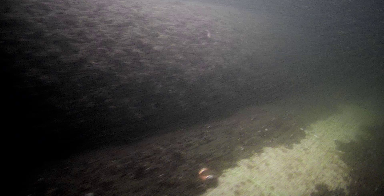

---
Predicted visibility: Very Good


In [ ]:
print('Test Image: '+test_image_path)
print('---')
cv2_imshow(output_image)
print('---')
print("Predicted visibility:",result)


### MORE WORK DONE BELOW TO PREDICT AND CREATE CONFUSION MATRIX

In [ ]:
CM_preds = model_1.predict_generator(val_batches)
# Get most likely class
CM_preds_classes = np.argmax(CM_preds, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
true_classes = val_batches.classes
class_labels = list(val_batches.class_indices.keys())   

In [ ]:
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

              precision    recall  f1-score   support

        Good       0.15      0.15      0.15        60
    Moderate       0.15      0.15      0.15        60
        Poor       0.30      0.27      0.28        60
   Very Good       0.18      0.18      0.18        60
   Very Poor       0.28      0.32      0.30        60

    accuracy                           0.21       300
   macro avg       0.21      0.21      0.21       300
weighted avg       0.21      0.21      0.21       300



In [ ]:
import sklearn.metrics as metrics
%matplotlib Inline
from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.pyplot as plot
#matplotlib.pyplot.plot([1,2,3,4,5],[5,4,3,2,1],"bx")


In [ ]:
y_pred=model_1.predict(X_val) 
y_pred=np.argmax(y_pred, axis=1)
y_val=np.argmax(y_val, axis=1)
cm = confusion_matrix(y_val, y_pred)
print(cm)

2/2 [==============================] - 1s 220ms/step


AxisError: ignored

In [ ]:
cm = confusion_matrix(y_val, y_pred)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
mcm = multilabel_confusion_matrix(y_val, y_pred)#,labels=["Good","Moderate","Poor","Very Good","Very Poor"])
print(mcm)
print('---')
print(label_map)


[[[42  0]
  [ 0  8]]

 [[38  1]
  [ 0 11]]

 [[37  1]
  [ 3  9]]

 [[41  0]
  [ 0  9]]

 [[38  2]
  [ 1  9]]]
---
{'Good': 0, 'Moderate': 1, 'Poor': 2, 'Very Good': 3, 'Very Poor': 4}


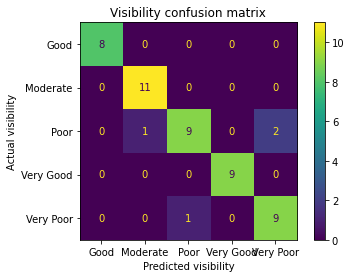

In [ ]:
## Print the Confusion Matrix.
## Create the Confusion Matrix Display Object(cmd_obj). Note the 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=["Good","Moderate","Poor","Very Good","Very Poor"])
cmd_obj.plot()
## Use the Axes attribute 'ax_' to get to the underlying Axes object.
cmd_obj.ax_.set(
                title='Visibility confusion matrix', 
                xlabel='Predicted visibility', 
                ylabel='Actual visibility')
plt.show()

In [ ]:
####Will also need to remove the header, maybe? depends on the predictions when doing it for real
####

MODEL_1 - baseline

In [ ]:
predictions = model_1.predict(x=test.astype("float32"), batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

MODEL_2 - transfer learning

In [ ]:
model_2 = keras.models.load_model('/content/drive/MyDrive/Ocean_Infinity/Output/Model_2/')